In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import math
import sys
PROJECT_DIR = "/content/drive/Shareddrives/CNN"
os.chdir(PROJECT_DIR)

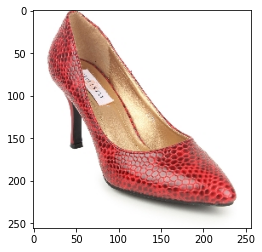

In [3]:
img1 = cv2.imread("./image/19962.jpg")
img2 = cv2.imread("./image/19901.jpg")
img3 = cv2.imread("./image/19885.jpg")
img4 = cv2.imread("./image/19842.jpg")
imgRGB1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
imgRGB2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
imgRGB3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
imgRGB4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
imgHSV1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
imgHSV2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
imgHSV3 = cv2.cvtColor(img3, cv2.COLOR_BGR2HSV)
imgHSV4 = cv2.cvtColor(img4, cv2.COLOR_BGR2HSV)
plt.imshow(imgRGB1)

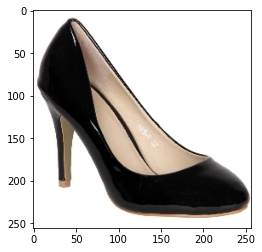

In [4]:
plt.imshow(imgRGB2)

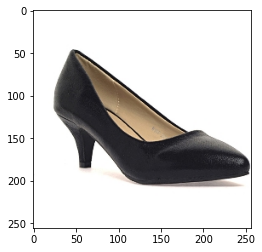

In [5]:
plt.imshow(imgRGB3)

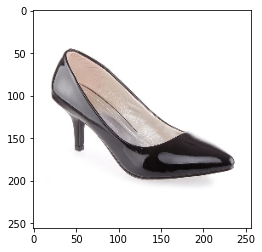

In [6]:
plt.imshow(imgRGB4)

In [7]:
# Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].
def split_color(img, num_of_part):
    delta_h = int(180/num_of_part[0])
    delta_s = int(256/num_of_part[1])
    delta_v = int(256/num_of_part[2])
    results = {}
    h = 0
    while h in range(180):
        s = 0
        while s in range(256):
            v = 0
            while v in range(256):
                if h==0:    # 紅色需分兩段處理
                    lower = np.array([179-int((delta_h-1)/2)+1, s, v])
                    upper = np.array([179, s+delta_s-1, v+delta_v-1])
                    mask1 = cv2.inRange(img, lower, upper)

                    lower2 = np.array([h, s, v])
                    upper2 = np.array([h+int((delta_h-1)/2), s+delta_s-1, v+delta_v-1])
                    mask2 = cv2.inRange(img, lower2, upper2)

                    mask = mask1 | mask2
                else:
                    lower = np.array([h-int((delta_h-1)/2), s, v])
                    upper = np.array([h+int((delta_h-1)/2), s+delta_s-1, v+delta_v-1])
                    mask = cv2.inRange(img, lower, upper)
                results.update({(h,s,v):mask})
                v += delta_v
            s += delta_s
        h += delta_h
    print("Slpit image into %s colors."%len(results))
    final_img = np.zeros(img.shape, dtype="uint8")
    for each_color in results:
        # print(each)
        color_template = results[each_color]/255    # binary: 1,0
        color_template = np.array(color_template, dtype="uint8")
        color_template = cv2.cvtColor(color_template, cv2.COLOR_GRAY2RGB)*each_color    # hsv
        color_template = np.array(color_template, dtype="uint8")
        color_template = cv2.cvtColor(color_template, cv2.COLOR_HSV2RGB)    # rgb
        final_img = cv2.add(final_img, color_template)
    return final_img
    
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex

def hex2rgb(hex):
    r = hex[1:3]
    g = hex[3:5]
    b = hex[5:7]
    r = int("0x"+r, 16)
    g = int("0x"+g, 16)
    b = int("0x"+b, 16)
    return [r, g, b]

def plot_image_info(img, top=5):
    # reshape the image to be a list of pixels
    img_list = img.reshape((img.shape[0]*img.shape[1], 3))
    d = {}
    for each in img_list:
        t = tuple(each)
        try:
            d[t] += 1
        except:
            d[t] = 1

    # select the 5-most frequently-appeared colors
    c = Counter(d).most_common(top)

    ordered_colors = []
    ordered_labels = []
    for each in c:
        ordered_colors.append([each[0][0]/255, each[0][1]/255, each[0][2]/255])
        ordered_labels.append(rgb2hex(each[0]))
    label_counts = [each[1] for each in c]
    
    # plots
    plt.figure(figsize=(14, 8))
    plt.subplot(221)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(222)
    plt.pie(label_counts, labels=ordered_labels, colors=ordered_colors, startangle=90)
    plt.axis('equal')
    plt.show()
    return c

### 結果

Slpit image into 768 colors.


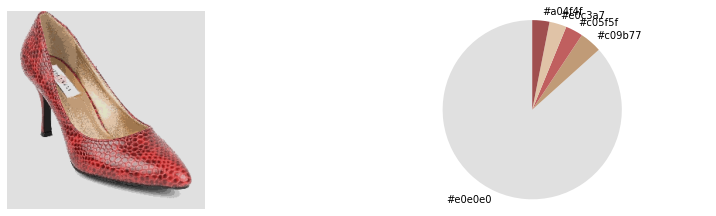

In [8]:
final_img1 = split_color(imgHSV1, (12,8,8))
color_set_1 = plot_image_info(final_img1)

### 相比於直接將圖片的畫素降低

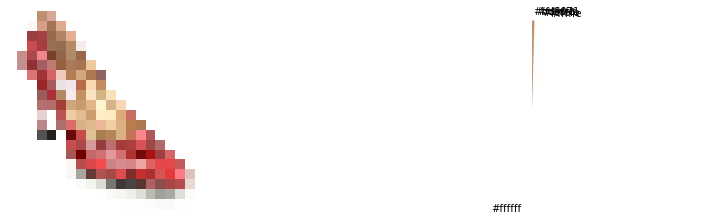

[((255, 255, 255), 227),
 ((255, 255, 254), 3),
 ((254, 254, 254), 2),
 ((253, 253, 251), 2),
 ((189, 144, 113), 1)]

In [9]:
resized = cv2.resize(imgRGB1, (20, 20), interpolation = cv2.INTER_CUBIC)
plot_image_info(resized)

### 算距離、排序

In [16]:
def color_distance(color_set_1, color_set_2):
    total_distance = 0
    total_1 = 0
    total_2 = 0
    for i in range(len(color_set_1)):
        total_1 += color_set_1[i][1]
        total_2 += color_set_2[i][1]
    for each in color_set_1:
        percentage_1 = each[1]/total_1
        # percentage_2 = 0
        r1, g1, b1 = each[0]
        # print("r1: %s, g1: %s, b1: %s" % (r1, g1, b1))
        min_distance = float("inf")
        for i in color_set_2:
            r2, g2, b2 = i[0]
            # print("r2: %s, g2: %s, b2: %s" % (r2, g2, b2))
            local_distance = math.sqrt(abs(r1-r2)**2+abs(g1-g2)**2+abs(b1-b2))
            # print("local distance: %s" % local_distance)
            if local_distance < min_distance:
                # percentage_2 = i[1]/total_2
                min_distance = local_distance
        total_distance += (min_distance * percentage_1)
        # total_distance += (min_distance * percentage_1 * percentage_2)
        # print("total distance: %s" % total_distance)
        # print("---------------------------------------")
    print("total distance: %s" % total_distance)
    print(color_set_2)
    return total_distance
def color_most_similar(img_1, otherImgs):
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2HSV)
    img_1 = split_color(img_1, (12,8,8))
    color_set_1 = plot_image_info(img_1)
    min_distance = float("inf")
    result = []
    for each in otherImgs:
        img_2 = cv2.cvtColor(each, cv2.COLOR_BGR2HSV)
        img_2 = split_color(img_2, (12,8,8))
        color_set_2 = plot_image_info(img_2)
        result.append([color_distance(color_set_1, color_set_2), each])
        result = sorted(result, key=lambda x:x[0], reverse=False)
    for each in result:
        plt.figure(figsize=(14, 8))
        plt.subplot(221)
        plt.imshow(cv2.cvtColor(each[1], cv2.COLOR_BGR2RGB))
        # if distance < min_distance:
        #     min_distance = distance
# print(color_distance(color_set_1, color_set_2))
# print(color_distance(color_set_1, color_set_3))
# print(color_distance(color_set_2, color_set_3))
# print(color_distance(color_set_2, color_set_2))

Slpit image into 768 colors.


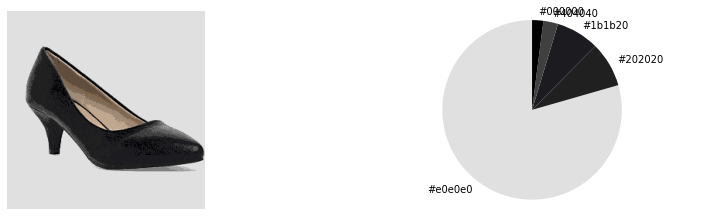

Slpit image into 768 colors.


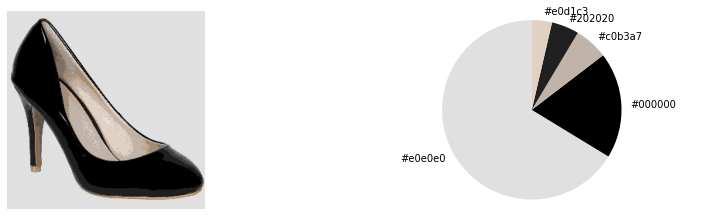

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


total distance: 4.202092014391893
[((224, 224, 224), 38854), ((0, 0, 0), 11195), ((192, 179, 167), 3531), ((32, 32, 32), 2901), ((224, 209, 195), 2126)]
Slpit image into 768 colors.


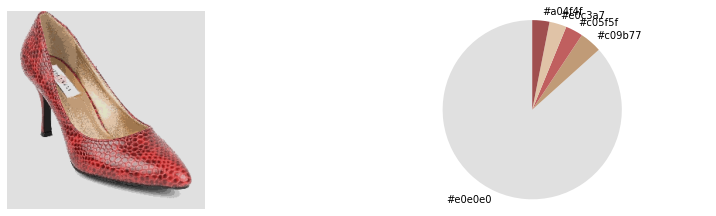

total distance: 18.409697847793403
[((224, 224, 224), 41845), ((192, 155, 119), 1925), ((192, 95, 95), 1518), ((224, 195, 167), 1500), ((160, 79, 79), 1495)]
Slpit image into 768 colors.


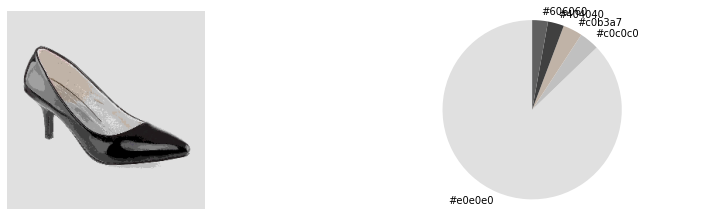

total distance: 14.810550432498065
[((224, 224, 224), 50771), ((192, 192, 192), 2071), ((192, 179, 167), 2038), ((64, 64, 64), 1685), ((96, 96, 96), 1652)]


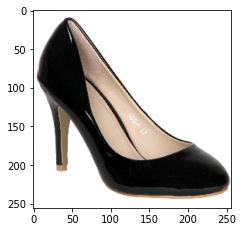

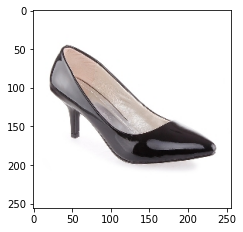

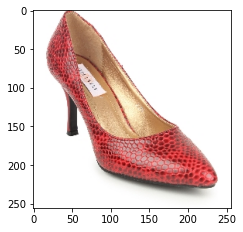

In [17]:
color_most_similar(img3, [img2, img1, img4])

In [13]:
img2.dtype

dtype('uint8')